# 1. Dataset Integrity

In this section, I verify that the train, dev, and test datasets were generated correctly.  
Checklist includes:
- Loading all dataset splits  
- Confirming shapes (rows, columns)  
- Checking that all participants exist  
- Verifying column consistency across splits  
- Checking for missing values  
- Ensuring no duplicate rows  

In [2]:
import pandas as pd
import os

train_path = "../../datasets/train.csv"
dev_path   = "../../datasets/dev.csv"
test_path  = "../../datasets/test.csv"

train = pd.read_csv(train_path)
dev   = pd.read_csv(dev_path)
test  = pd.read_csv(test_path)

train.head(), dev.head(), test.head()

(      mean_0      mean_1     mean_2     mean_3     mean_4     mean_5  \
 0 -362.99182   68.347015 -54.911198 -28.917810 -46.511013 -41.882435   
 1 -390.16736   75.881360 -52.958310 -19.148077 -39.122395 -43.061190   
 2 -218.66693  117.282906 -46.413692 -38.184950 -38.190323 -42.230007   
 3 -356.32123   61.632870 -54.163982 -24.879112 -43.862880 -39.142593   
 4 -355.81293   62.362220 -31.367554 -21.111980 -38.521282 -40.111430   
 
       mean_6     mean_7     mean_8     mean_9  ...    max_94    max_95  \
 0 -37.037640 -25.671257 -19.659122 -17.705473  ...  0.395999  0.045656   
 1 -30.862331 -17.859287 -16.020120 -11.854240  ...  0.302670  0.075260   
 2 -39.041813 -34.752377 -20.231236 -19.281492  ...  0.101275  0.538433   
 3 -50.619987 -34.266033 -32.399740 -12.326344  ...  0.407933  0.038784   
 4 -40.570816 -35.850765 -27.584566 -14.146144  ...  1.000001  0.065709   
 
      max_96    max_97    max_98    max_99   max_100   max_101   max_102  \
 0  0.648193  0.696052  0.693428

In [3]:
print("Train shape:", train.shape)
print("Dev shape:  ", dev.shape)
print("Test shape: ", test.shape)

print("\nColumn count comparison:")
print("Train columns:", len(train.columns))
print("Dev columns:  ", len(dev.columns))
print("Test columns: ", len(test.columns))

Train shape: (107, 413)
Dev shape:   (35, 413)
Test shape:  (47, 413)

Column count comparison:
Train columns: 413
Dev columns:   413
Test columns:  413


In [4]:
print("Missing values in Train:", train.isnull().sum().sum())
print("Missing values in Dev:",   dev.isnull().sum().sum())
print("Missing values in Test:",  test.isnull().sum().sum())

Missing values in Train: 0
Missing values in Dev: 0
Missing values in Test: 0


In [5]:
print("Missing values per column (Train):")
display(train.isnull().sum()[train.isnull().sum() > 0])

print("Missing values per column (Dev):")
display(dev.isnull().sum()[dev.isnull().sum() > 0])

print("Missing values per column (Test):")
display(test.isnull().sum()[test.isnull().sum() > 0])

Missing values per column (Train):


Series([], dtype: int64)

Missing values per column (Dev):


Series([], dtype: int64)

Missing values per column (Test):


Series([], dtype: int64)

In [6]:
print("Duplicate rows in Train:", train.duplicated().sum())
print("Duplicate rows in Dev:",   dev.duplicated().sum())
print("Duplicate rows in Test:",  test.duplicated().sum())

Duplicate rows in Train: 0
Duplicate rows in Dev: 0
Duplicate rows in Test: 0


In [7]:
assert "PHQ_score" in train.columns, "Missing PHQ_score in Train"
assert "PHQ_score" in dev.columns,   "Missing PHQ_score in Dev"
assert "PHQ_score" in test.columns,  "Missing PHQ_score in Test"

print("PHQ_score column present in all datasets.")

PHQ_score column present in all datasets.


# 2. Target Variable Analysis — PHQ_score

In this section, I analyze the distribution and properties of the target variable (PHQ_score).  
This includes:
- Descriptive statistics  
- Distribution visualization  
- Outlier detection  
- Skewness analysis  

This step helps understand:
- Regression difficulty  
- Label imbalance  
- Whether transformations are needed  

In [8]:
full_train = pd.concat([train, dev], ignore_index=True)
print("Full Train Shape:", full_train.shape)

full_train["PHQ_score"].head()

Full Train Shape: (142, 413)


0    0.0
1    6.0
2    7.0
3    4.0
4    2.0
Name: PHQ_score, dtype: float64

In [9]:
full_train["PHQ_score"].describe()

count    142.000000
mean       6.669014
std        5.753472
min        0.000000
25%        2.000000
50%        5.500000
75%       10.000000
max       23.000000
Name: PHQ_score, dtype: float64

- less training data, so complex models may overfit
- need to use legularization techniques properly
- LightGBM/XGBoost seems appropriate
- higher std, harder regression task
- Distribution seems to be rightly skewed

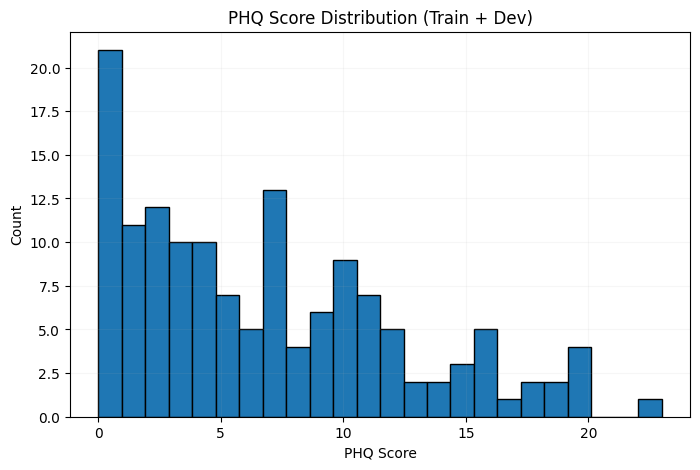

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(full_train["PHQ_score"], bins=24, edgecolor="black")
plt.title("PHQ Score Distribution (Train + Dev)")
plt.xlabel("PHQ Score")
plt.ylabel("Count")
plt.grid(alpha=0.1)
plt.show()

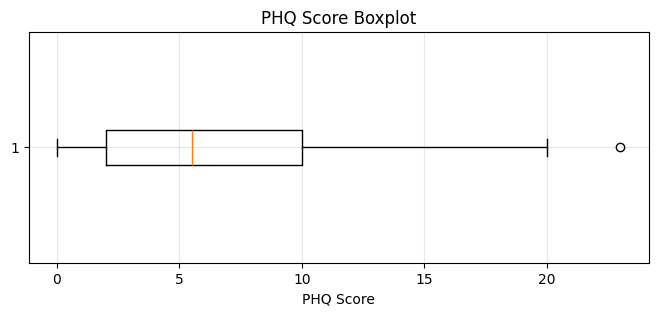

In [15]:
plt.figure(figsize=(8, 3))
plt.boxplot(full_train["PHQ_score"], vert=False)
plt.title("PHQ Score Boxplot")
plt.xlabel("PHQ Score")
plt.grid(alpha=0.3)
plt.show()

In [16]:
phq_skew = full_train["PHQ_score"].skew()
phq_skew

np.float64(0.7651794718747046)

- more low score, and few high ones, since the skewness is positive

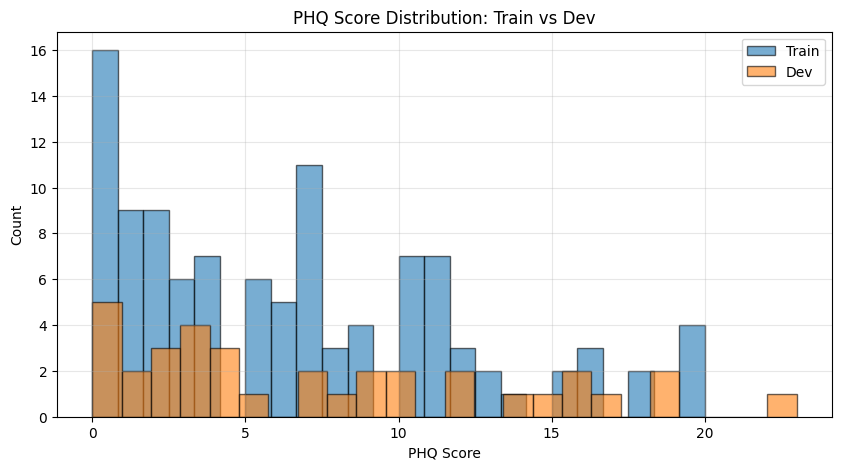

In [18]:
plt.figure(figsize=(10, 5))

plt.hist(train["PHQ_score"], bins=24, alpha=0.6, label="Train", edgecolor="black")
plt.hist(dev["PHQ_score"],   bins=24, alpha=0.6, label="Dev",   edgecolor="black")

plt.title("PHQ Score Distribution: Train vs Dev")
plt.xlabel("PHQ Score")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 3. Summary Feature Statistics

In this section, I explore descriptive statistics for all summary-level audio features.
This helps identify:
- Unusual feature scales
- Extremely large or small values
- Features with unexpected distributions
- Potential preprocessing issues
- Whether any features appear unstable or noisy

This step is essential because summary features come from MFCC, chroma, spectral, rms, zcr, and tonnetz feature families.

In [19]:
# Exclude target column
feature_cols = [c for c in full_train.columns if c != "PHQ_score"]

len(feature_cols), feature_cols[:10]

(412,
 ['mean_0',
  'mean_1',
  'mean_2',
  'mean_3',
  'mean_4',
  'mean_5',
  'mean_6',
  'mean_7',
  'mean_8',
  'mean_9'])

In [20]:
feature_stats = full_train[feature_cols].describe().T
feature_stats

,count,mean,std,min,25%,50%,75%,max
mean_0,142.0,-412.574709,54.096761,-542.446400,-448.470320,-413.843100,-387.479287,-179.670610
mean_1,142.0,67.268043,11.021412,39.495490,59.807185,67.515465,73.791481,117.282906
mean_2,142.0,-52.153057,11.625617,-79.087130,-60.040252,-52.324458,-44.842096,-26.642763
mean_3,142.0,-23.587107,7.340982,-40.837950,-28.919470,-23.231079,-18.165816,-3.258156
mean_4,142.0,-44.878689,7.656211,-65.077095,-49.227317,-45.284727,-38.938147,-26.460040
...,...,...,...,...,...,...,...,...
max_98,142.0,0.602998,0.116256,0.262716,0.510879,0.627204,0.698636,0.830473
max_99,142.0,0.689689,0.083821,0.439690,0.627334,0.702410,0.752757,0.927168
max_100,142.0,0.631138,0.106778,0.308500,0.561768,0.610781,0.710141,0.875779
max_101,142.0,0.252916,0.036438,0.177012,0.226692,0.252113,0.276349,0.386876


In [21]:
zero_variance = feature_stats[feature_stats["std"] == 0]
zero_variance

,count,mean,std,min,25%,50%,75%,max
max_80,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_81,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_82,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_83,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_84,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_85,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_86,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_87,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_88,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_89,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


These columns are useless for model training.

In [22]:
low_variance = feature_stats[feature_stats["std"] < 1e-6]
low_variance

,count,mean,std,min,25%,50%,75%,max
max_80,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_81,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_82,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_83,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_84,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_85,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_86,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_87,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_88,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
max_89,142.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [23]:
unusual_max = feature_stats[feature_stats["max"] > feature_stats["75%"] * 50]
unusual_min = feature_stats[feature_stats["min"] < feature_stats["25%"] * 0.01]

unusual_max, unusual_min

(         count        mean        std         min         25%         50%  \
 mean_0   142.0 -412.574709  54.096761 -542.446400 -448.470320 -413.843100   
 mean_2   142.0  -52.153057  11.625617  -79.087130  -60.040252  -52.324458   
 mean_3   142.0  -23.587107   7.340982  -40.837950  -28.919470  -23.231079   
 mean_4   142.0  -44.878689   7.656211  -65.077095  -49.227317  -45.284727   
 mean_5   142.0  -38.403699   5.549420  -51.732754  -42.179012  -38.763296   
 ...        ...         ...        ...         ...         ...         ...   
 min_99   142.0   -0.638192   0.094169   -0.886633   -0.701348   -0.619237   
 min_100  142.0   -0.638118   0.100146   -0.885114   -0.702943   -0.629844   
 min_101  142.0   -0.283371   0.048567   -0.360031   -0.319480   -0.298454   
 min_102  142.0   -0.202630   0.015658   -0.233210   -0.215198   -0.203872   
 max_0    142.0 -178.940637  69.937385 -323.397670 -225.781065 -188.672660   
 
                 75%         max  
 mean_0  -387.479287 -179.6

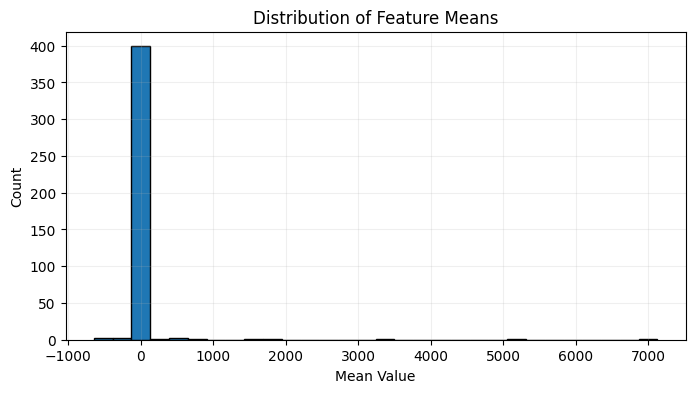

In [24]:
plt.figure(figsize=(8, 4))
plt.hist(feature_stats["mean"], bins=30, edgecolor="black")
plt.title("Distribution of Feature Means")
plt.xlabel("Mean Value")
plt.ylabel("Count")
plt.grid(alpha=0.2)
plt.show()

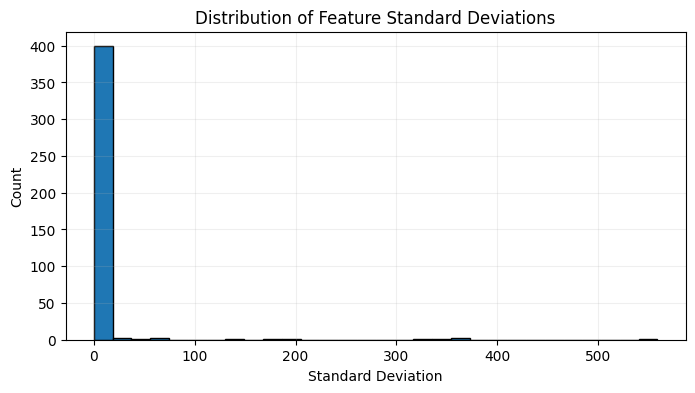

In [25]:
plt.figure(figsize=(8, 4))
plt.hist(feature_stats["std"], bins=30, edgecolor="black")
plt.title("Distribution of Feature Standard Deviations")
plt.xlabel("Standard Deviation")
plt.ylabel("Count")
plt.grid(alpha=0.2)
plt.show()

# 4. Missing Value Check (Feature-wise)

In this section, I verify that no missing values (NaN, None, infinite values) exist in the summary-level dataset.
Although the feature extraction pipeline should not produce missing values, errors can occur from:
- Audio preprocessing issues
- Feature extraction instability
- Faulty summary file writes
- Parsing errors

This check ensures dataset integrity before variance analysis and model training.

In [26]:
print("Train missing values:", train.isnull().sum().sum())
print("Dev missing values:",   dev.isnull().sum().sum())
print("Full Train missing values:", full_train.isnull().sum().sum())

Train missing values: 0
Dev missing values: 0
Full Train missing values: 0


In [27]:
missing_cols = full_train.columns[ full_train.isnull().any() ]
missing_cols

Index([], dtype='object')

In [28]:
full_train[missing_cols].isnull().sum()

Series([], dtype: float64)

In [29]:
import numpy as np

inf_mask = full_train.replace([np.inf, -np.inf], np.nan)
inf_counts = inf_mask.isnull().sum().sum()

print("Number of infinite values:", inf_counts)

Number of infinite values: 0


In [30]:
inf_cols = full_train.columns[inf_mask.isnull().any()]
inf_cols

Index([], dtype='object')

# 5. Feature Variance Analysis

In this section, I analyze the variance of each summary feature across the full training dataset.
Variance helps identify:
- Stable features (high variance = potentially informative)
- Useless features (zero or extremely low variance)
- Noisy or unstable features (extremely high variance)

This helps determine which features should be kept for modeling and which may require removal or special handling.

In [31]:
variances = full_train[feature_cols].var()
variances.head()

mean_0    2926.459556
mean_1     121.471531
mean_2     135.154961
mean_3      53.890014
mean_4      58.617567
dtype: float64

In [32]:
low_var = variances.sort_values().head(20)
low_var

max_84    0.000000e+00
max_91    0.000000e+00
max_90    0.000000e+00
max_89    0.000000e+00
max_88    0.000000e+00
max_87    0.000000e+00
max_86    0.000000e+00
max_85    0.000000e+00
max_83    0.000000e+00
max_82    0.000000e+00
max_81    0.000000e+00
max_80    0.000000e+00
min_94    1.206864e-08
min_95    1.606982e-07
min_84    4.297753e-06
min_82    4.777486e-06
min_83    5.851842e-06
min_81    6.119671e-06
min_89    6.344373e-06
min_85    6.961454e-06
dtype: float64

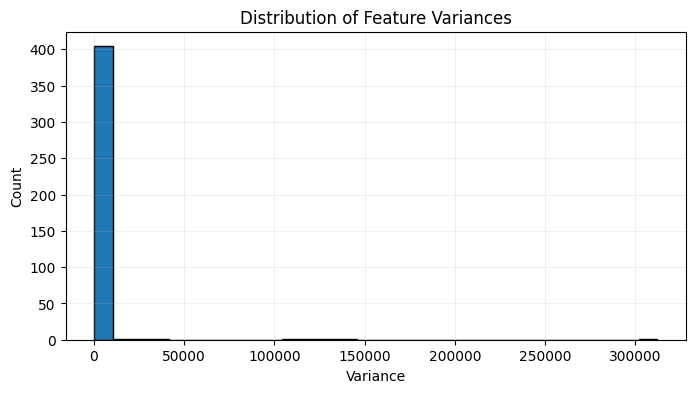

In [33]:
plt.figure(figsize=(8, 4))
plt.hist(variances, bins=30, edgecolor="black")
plt.title("Distribution of Feature Variances")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.grid(alpha=0.2)
plt.show()

In [34]:
low_variance_threshold = 1e-4
num_low_var = (variances < low_variance_threshold).sum()
num_low_var

np.int64(30)

# 6. Correlation With PHQ_score

In this section, I compute the Pearson correlation between each summary feature
and the target variable (PHQ_score).

Purpose:
- Identify the most predictive audio features
- Determine which feature families contribute the most (MFCC, chroma, spectral, RMS, ZCR, tonnetz)
- Spot irrelevant or weak features
- Understand the structure of the regression task

Note: Correlation does not capture nonlinear relationships, but still provides valuable signal for feature importance.

In [35]:
# Exclude the label column
feature_cols = [c for c in full_train.columns if c != "PHQ_score"]

correlations = full_train[feature_cols].corrwith(full_train["PHQ_score"])
correlations = correlations.to_frame("corr")
correlations["abs_corr"] = correlations["corr"].abs()

correlations.head()

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr,abs_corr
mean_0,-0.159010,0.159010
mean_1,-0.100155,0.100155
mean_2,0.110732,0.110732
mean_3,-0.070956,0.070956
mean_4,0.110311,0.110311


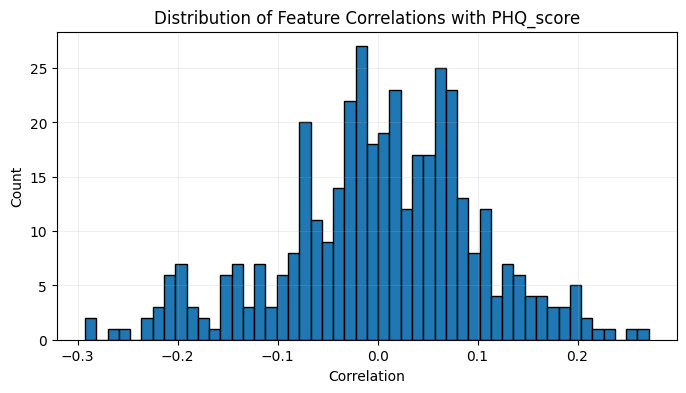

In [36]:
plt.figure(figsize=(8, 4))
plt.hist(correlations["corr"], bins=50, edgecolor="black")
plt.title("Distribution of Feature Correlations with PHQ_score")
plt.xlabel("Correlation")
plt.ylabel("Count")
plt.grid(alpha=0.2)
plt.show()

In [38]:
top20 = correlations.sort_values("abs_corr", ascending=False).head(20)
top20

,corr,abs_corr
max_50,-0.292692,0.292692
max_54,-0.285522,0.285522
min_50,0.271258,0.271258
max_51,-0.261819,0.261819
max_52,-0.255366,0.255366
min_49,0.250121,0.250121
max_53,-0.233307,0.233307
max_55,-0.228737,0.228737
mean_5,0.227302,0.227302
std_53,-0.224252,0.224252


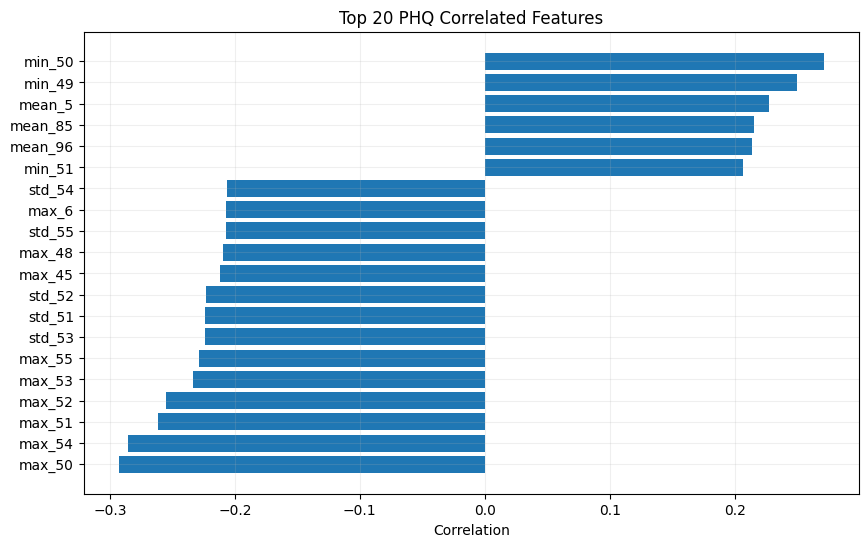

In [39]:
top20_sorted = top20.sort_values("corr")

plt.figure(figsize=(10, 6))
plt.barh(top20_sorted.index, top20_sorted["corr"])
plt.title("Top 20 PHQ Correlated Features")
plt.xlabel("Correlation")
plt.grid(alpha=0.2)
plt.show()

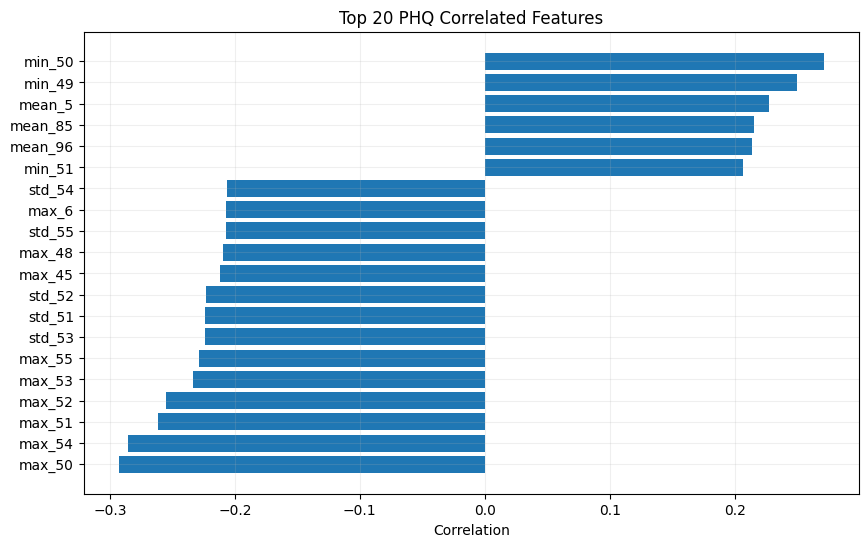

In [41]:
top20_sorted = top20.sort_values("corr")

plt.figure(figsize=(10, 6))
plt.barh(top20_sorted.index, top20_sorted["corr"])
plt.title("Top 20 PHQ Correlated Features")
plt.xlabel("Correlation")
plt.grid(alpha=0.2)
plt.show()